In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
import pickle
import os

In [2]:
import dataset_utils
from glob import glob

In [12]:
DATA_DIR = "pointnet_data"
NUM_POINTS = 40
NUM_CLASSES = 2
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

processing class: sit
processing class: stand


In [13]:
print(train_points)

[[[ 4.6777e-01  1.6931e-01  1.7227e+00  0.0000e+00  1.3200e+02]
  [-4.3164e-01  1.5801e+00  8.9355e-01  2.5049e-01  3.3500e+02]
  [ 1.1426e+00  3.3105e+00  4.3652e-01  3.7573e-01  1.3100e+02]
  ...
  [-2.1523e+00  2.0508e+00  8.6914e-01  0.0000e+00  2.1200e+02]
  [ 4.6777e-01  1.7175e-01  1.7246e+00  0.0000e+00  1.3500e+02]
  [-1.9922e+00  9.4238e-01  1.8604e+00  0.0000e+00  1.7400e+02]]

 [[-1.9922e+00  9.4092e-01  1.8457e+00  0.0000e+00  1.7800e+02]
  [ 1.0605e+00  3.2773e+00  7.4902e-01  2.5049e-01  1.6100e+02]
  [-2.9834e-01  1.6016e+00  9.0137e-01  5.0098e-01  2.4700e+02]
  ...
  [-2.0254e+00  2.9712e-01  1.5117e+00  0.0000e+00  1.3800e+02]
  [-2.0254e+00  3.2520e-01  1.5293e+00  0.0000e+00  1.4300e+02]
  [-1.9922e+00  9.3945e-01  1.8379e+00  0.0000e+00  1.8100e+02]]

 [[ 8.4766e-01  3.7266e+00  1.0674e+00 -2.5049e-01  3.2700e+02]
  [ 8.4619e-01  3.8828e+00  9.9707e-01 -1.2524e-01  3.1500e+02]
  [ 6.4551e-01  3.9062e-01 -9.3750e-02  0.0000e+00  1.2500e+02]
  ...
  [ 4.2358e-01  2.

In [14]:
train_points = [sample[:,:3] for sample in train_points]
test_points = [sample[:,:3] for sample in test_points]
print(CLASS_MAP)

{0: 'sit', 1: 'stand'}


In [15]:
print(test_points)

[array([[ 1.2295,  3.887 ,  1.016 ],
       [ 1.295 ,  3.873 ,  1.171 ],
       [ 1.236 ,  3.887 ,  1.193 ],
       [ 1.25  ,  3.996 ,  1.06  ],
       [ 1.295 ,  3.928 ,  1.126 ],
       [ 1.2295,  3.95  ,  0.9717],
       [ 0.8   ,  0.4727, -0.252 ],
       [-1.202 ,  0.5273,  3.77  ],
       [-1.202 ,  0.4727,  3.611 ],
       [-1.202 ,  0.496 ,  3.688 ],
       [-1.202 ,  0.59  ,  3.926 ],
       [ 0.6455,  0.504 , -0.2969],
       [ 1.171 ,  4.16  ,  0.8896],
       [ 1.16  ,  4.14  ,  0.9463],
       [-1.202 ,  0.5   ,  3.7   ],
       [ 1.25  ,  4.008 ,  1.051 ],
       [ 1.277 ,  4.453 ,  0.7793],
       [-0.1543,  4.207 ,  1.138 ],
       [ 1.277 ,  4.01  ,  0.95  ],
       [ 1.236 ,  3.955 ,  1.138 ],
       [ 1.323 ,  3.85  ,  1.27  ],
       [ 0.6606,  3.273 ,  2.242 ],
       [ 0.6455,  0.5273, -0.3398],
       [ 1.279 ,  3.945 ,  1.163 ],
       [-1.202 ,  0.4492,  3.535 ],
       [-1.202 ,  0.4922,  3.672 ],
       [ 0.8   ,  0.5625, -0.4043],
       [ 1.264 ,  3.879 ,  

In [16]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [17]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [18]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn

In [19]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 40, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 40, 32)    │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 32)    │        128 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 40, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 40, 64)    │      2,112 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 64)    │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 40, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 40, 512)   │     33,280 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 512)   │      2,048 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 40, 512)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_19[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 9)         │      1,161 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 3, 3)      │          0 │ dense_11[0][0]  

 Total params: 747,947 (2.85 MB)

 Trainable params: 741,867 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [20]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 52.8168 - sparse_categorical_accuracy: 0.7620 - val_loss: 48949408.0000 - val_sparse_categorical_accuracy: 0.4884
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 35.0935 - sparse_categorical_accuracy: 0.9094 - val_loss: 1386899.3750 - val_sparse_categorical_accuracy: 0.2713
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 34.8104 - sparse_categorical_accuracy: 0.9510 - val_loss: 6165.9023 - val_sparse_categorical_accuracy: 0.8760
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 34.2807 - sparse_categorical_accuracy: 0.9767 - val_loss: 122238.4609 - val_sparse_categorical_accuracy: 0.6047
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 34.2756 - sparse_categorical_accuracy: 0.9665 - val_loss: 2570594.7500 - val_sparse_categorical_accuracy: 0.2403
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 34.3677 - sparse_categorical_accuracy: 0.9738 - val_loss: 225107968.0000 - val_spars

In [21]:
from matplotlib import pyplot as plt

2024-08-01 16:46:47.015757: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
[[[-2.066     0.254     1.604   ]
  [-2.152     2.055     0.874   ]
  [-0.7017    0.7295    0.6133  ]
  [-2.152     2.055     0.873   ]
  [-2.066     0.258     1.606   ]
  [-2.066     0.267     1.612   ]
  [-0.7017    0.7393    0.617   ]
  [-2.066     0.258     1.606   ]
  [-2.076     0.851     1.662   ]
  [-0.7017    0.741     0.619   ]
  [-0.7017    0.7295    0.6133  ]
  [-2.152     2.057     0.877   ]
  [-2.076     0.8506    1.662   ]
  [-2.066     0.267     1.612   ]
  [ 0.4678    0.1647    1.721   ]
  [-0.7017    0.7217    0.6084  ]
  [-0.7017    0.7344    0.615   ]
  [-2.076     0.85      1.661   ]
  [-0.7017    0.7476    0.623   ]
  [-2.076     0.8447    1.647   ]
  [-2.076     0.8477    1.654   ]
  [-2.152     2.053     0.872   ]
  [-2.152     2.055     0.874   ]
  [-2.076     0.845     1.648   ]
  [-2.066     0.258     1.606   ]
  [-0.7017    0.7437    0.62    ]
  [-2.076     0.8506    1.662   ]
  [-2.152     2.055     0.874   ]
  [-0.701

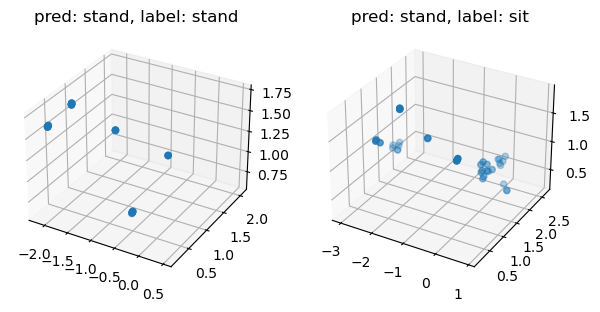

In [22]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(2):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()